In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [3]:
# need to run if there are updates to resolution, binning, or mephistograms
# %run ../../core/resolution.py
# %run ../../core/prepare_histograms.py

# Imports

In [2]:
import pickle
from collections import namedtuple
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2
from settings import *
from tools import array_source_interp
from tqdm import tqdm


# Settings

In [3]:
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_MH_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_MH_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_MH_up.pckl"),
}


In [4]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [5]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [6]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Detector configuration

## Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

## Atmospheric background

In [8]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


## Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [9]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)


## Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [10]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [11]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
flux_collection = {"powerlaw": PL_flux}

In [12]:
new_livetime = 3186 * 24 * 3600  # new ngc paper
old_livetime = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600 # old 10yr PS paper
old_ngc_events = 50.4 # phi 3E-14
new_ngc_events = 79 # phi 5E-14

In [13]:
new_ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
uncorrected_ngc_flux = PL_flux(PHI_NGC*1.07, GAMMA_NGC, E0_NGC, "powerlaw")
old_ngc_flux = PL_flux(3E-14, GAMMA_NGC, E0_NGC, "powerlaw")


In [14]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [16]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()

# old paper
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=old_livetime, **ngc_src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=old_ngc_flux,
)
print("old ngc 1068:", np.sum(k_s), ", should be", old_ngc_events)
# accounting for the fact that not every data set has 86-str
old_updated_livetime = old_livetime / np.sum(k_s) * old_ngc_events
print(
    "old:",
    old_livetime / (24 * 3600),
    "old_updated:",
    old_updated_livetime / (24 * 3600),
    "ratio:",
    old_ngc_events / np.sum(k_s),
)

# new paper
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=new_livetime, **ngc_src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=new_ngc_flux,
)

print("new ngc 1068:", np.sum(k_s))
print("should be:", new_ngc_events, "ratio:", new_ngc_events / np.sum(k_s))
new_updated_livetime = new_livetime * new_ngc_events / np.sum(k_s)

# cross check:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], livetime=new_updated_livetime, **ngc_src_config
)

print(
    "cross check:",
    np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=new_ngc_flux,
        )
    ),
) # :)


old ngc 1068: 57.37086392913273 , should be 50.4
old: 3576.1 old_updated: 3141.584903142395 ratio: 0.8784947018099033
new ngc 1068: 85.1875751415494
should be: 79 ratio: 0.9273652861785536
cross check: 78.99999999999999


# Set up LLH function

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know


For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$
* mu -> 0, k>0     --> P -> 0
* k -> 0, mu>0     --> P -> exp(-mu)
* k -> 0, mu -> 0  --> P -> 1

In [17]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    log_LLH = np.zeros_like(mu_i)
    # k == 0, mu > 0:
    _mask = (k_i == 0) & (mu_i > 0)
    log_LLH[_mask] = -mu_i[_mask]
    # k == 0, mu == 0:
    _mask = (k_i == 0) & (mu_i == 0)
    log_LLH[_mask] = 0
    # k > 0, mu==0: should not happen! we'll assign a very negative value
    _mask = (k_i > 0) & (mu_i == 0)
    log_LLH[_mask] = -1000
    # k > 0, mu > 0
    _mask = (k_i > 0) & (mu_i > 0)
    log_LLH[_mask] = (
        k_i[_mask] * np.log(mu_i[_mask])
        - mu_i[_mask]
        - 0.5 * np.log(2 * np.pi * k_i[_mask])
        + k_i[_mask]
        - k_i[_mask] * np.log(k_i[_mask])
    )

    return -2 * np.sum(log_LLH)


# Cross checks

## Old analysis

* E_res: baseline
* livetime: match number of events at horizon

In [18]:
ident = "IceCube"
decs = np.arange(0, 71, step=10)
# some reference flux, but we'll be scaling that anyway
gamma2_flux = PL_flux(1e-15, 2.0, E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [sigma5]
eres = baseline_eres
name = "base"
for dec in tqdm(np.deg2rad(decs)):
    if ident == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], livetime=old_updated_livetime, dec=dec, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[ident], livetime=old_updated_livetime, dec=dec, **src_config
    )
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
        energy_resolution=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        gamma2_flux,  # powerlaw
    )
    # calculate an estimate for the flux scaling
    scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:

        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            eres,
            scaler,
            gamma2_flux,  # powerlaw
        )
        k_i = k_s + k_b

        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=gamma2_flux.E0,
            phi_0=gamma2_flux.norm,
            energy_resolution=eres,
        )

        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": ident,
            "eres": name,
            "dec": dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == ident)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "gamma2_disc_pot_old_comparison.pickle"))


100%|██████████| 8/8 [00:24<00:00,  3.06s/it]


In [19]:
flux = pd.DataFrame(
    df.groupby(["eres", "dec"]).apply(lambda x: get_scaler(x, sigma5))
    * gamma2_flux.norm,
    columns=["disc5"],
).reset_index()


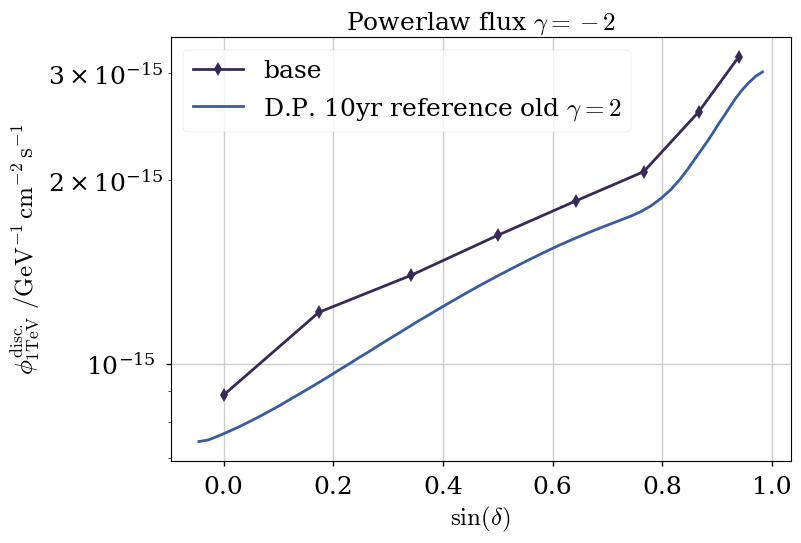

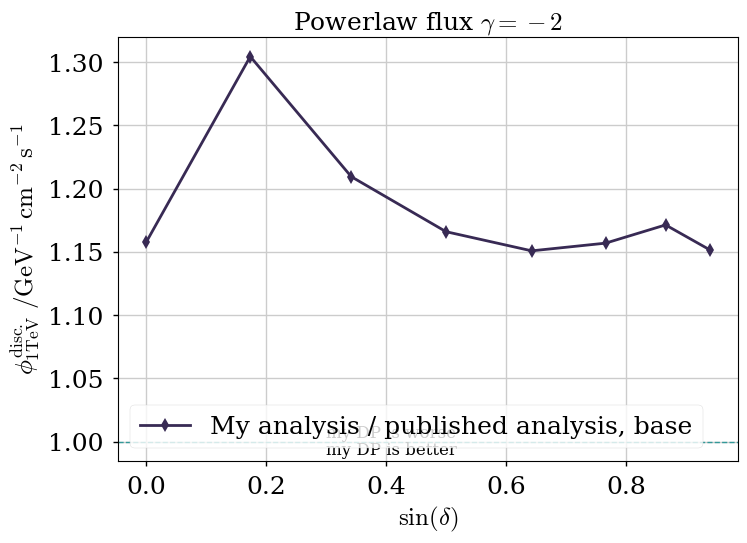

In [20]:
# comparison to DP from old 10yr PS paper

ps_disc_old = np.genfromtxt(
    "/home/lisajsch/repos/Plenum/local/ngc_DP_old_gamma-2.txt", delimiter=","
)

ind_disc_old = np.argsort(ps_disc_old[:, 0])
xsd_old = ps_disc_old[:, 0][ind_disc_old]
ic_10yr_old = ps_disc_old[:, 1][ind_disc_old]
spl_10yr_old = splrep(xsd_old, ic_10yr_old)

gamma = 2
ident = "IceCube"

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        label=eres,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
    )

ax.plot(
    xsd_old, ic_10yr_old * 1e-15, label=rf"D.P. 10yr reference old $\gamma={gamma}$"
)

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
# ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.legend(loc=0)
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot_old.pdf", bbox_inches="tight")

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5 / splev(np.sin(series.dec), spl_10yr_old) * 1e15,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
        label="My analysis / published analysis, " + eres,
    )
plt.axhline(1, ls="--", lw=1, color="#339999")
plt.text(0.3, 1.0, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.0, "my DP is worse", va="bottom", fontsize=12)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
ax.legend(loc=0)
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot_ratio_old.pdf", bbox_inches="tight")


## New analysis

In [21]:
ident = "IceCube"
decs = np.arange(0, 71, step=10)
# some reference flux, but we'll be scaling that anyway
gamma2_flux = PL_flux(1e-15, 2.0, E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [sigma5]
eres = improved_eres
name = "improved"
for dec in tqdm(np.deg2rad(decs)):
    if ident == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], livetime=new_updated_livetime, dec=dec, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[ident], livetime=new_updated_livetime, dec=dec, **src_config
    )
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
        energy_resolution=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        gamma2_flux,  # powerlaw
    )
    # calculate an estimate for the flux scaling
    scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:

        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            eres,
            scaler,
            gamma2_flux,  # powerlaw
        )
        k_i = k_s + k_b

        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=gamma2_flux.E0,
            phi_0=gamma2_flux.norm,
            energy_resolution=eres,
        )

        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": ident,
            "eres": name,
            "dec": dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == ident)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "gamma2_disc_pot_new_comparison.pickle"))


100%|██████████| 8/8 [00:24<00:00,  3.09s/it]


In [22]:
flux = pd.DataFrame(
    df.groupby(["eres", "dec"]).apply(lambda x: get_scaler(x, sigma5))
    * gamma2_flux.norm,
    columns=["disc5"],
).reset_index()


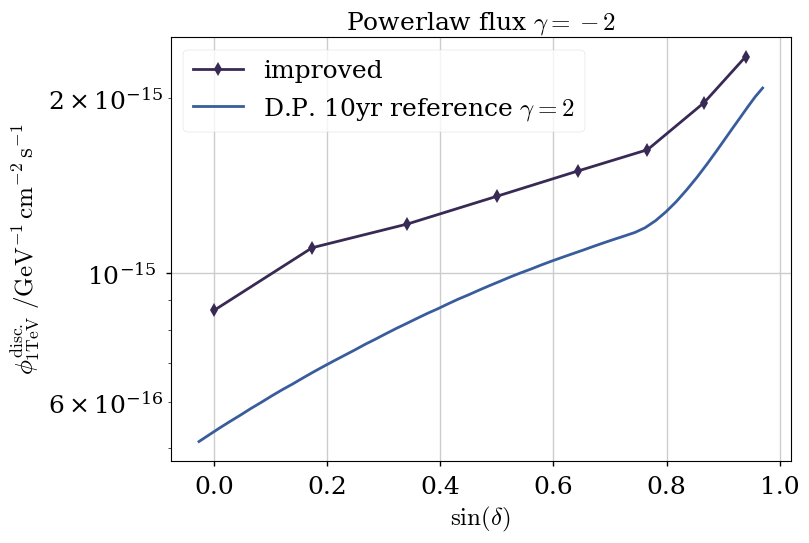

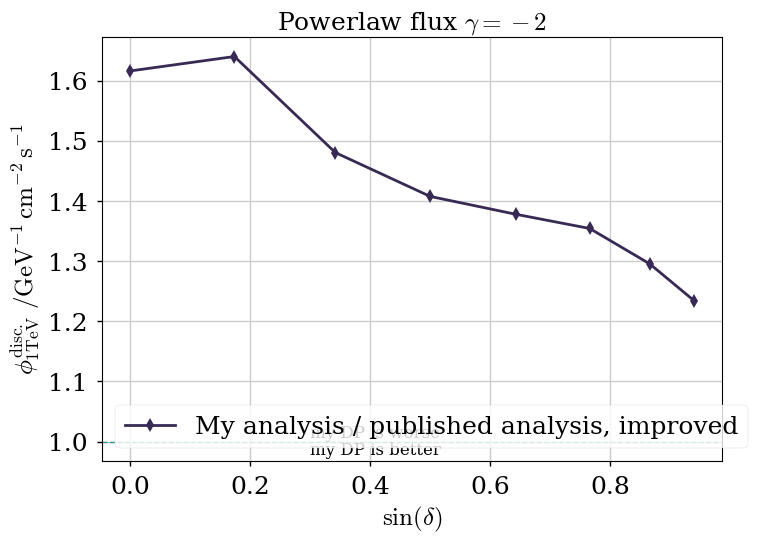

In [23]:
# comparison to DP from ngc paper

ps_disc = np.genfromtxt(
    "/home/lisajsch/repos/Plenum/local/ngc_DP_gamma-2.txt", delimiter=","
)

ind_disc = np.argsort(ps_disc[:, 0])
xsd = ps_disc[:, 0][ind_disc]
ic_10yr = ps_disc[:, 1][ind_disc]
spl_10yr = splrep(xsd, ic_10yr)

gamma = 2
ident = "IceCube"

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        label=eres,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
    )

ax.plot(xsd, ic_10yr * 1e-15, label=rf"D.P. 10yr reference $\gamma={gamma}$")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
# ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.legend(loc=0)
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot_new.pdf", bbox_inches="tight")

f, ax = plt.subplots()
for eres, series in flux.groupby(["eres"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5 / splev(np.sin(series.dec), spl_10yr) * 1e15,
        **{k: det_plotting[ident][k] for k in ["marker", "ls"]},
        label="My analysis / published analysis, " + eres,
    )
plt.axhline(1, ls="--", lw=1, color="#339999")
plt.text(0.3, 1.0, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.0, "my DP is worse", va="bottom", fontsize=12)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.set_title(rf"Powerlaw flux $\gamma=-{int(gamma)}$")
ax.legend(loc=0)
f.savefig(f"../../plots/gamma{int(gamma)}_disc_pot_ratio_new.pdf", bbox_inches="tight")
